Customer Segmentation for e-commerce client using RFM Analysis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv(r"cctv_ecommerce_dataset.csv",parse_dates=["Order_date", "Delivery_date"])

In [34]:
df.dtypes

Cust_id                     object
Cust_name                   object
Cust_age                     int64
Cust_gender                 object
City                        object
State                       object
Pin_code                    object
Order_id                     int64
Qty                          int64
Discount_amt               float64
Delivery_fees              float64
Total                      float64
Order_date          datetime64[ns]
Delivery_date       datetime64[ns]
Delivery_status             object
Shipping_Partner            object
Cust_review                 object
dtype: object

In [35]:
#Consider all the orders except 'Canceled'
df = df[df['Delivery_status'].isin(["Delivered", "Delayed","Returned"])]

In [36]:
now = '2025-05-31'
today = pd.to_datetime(now)

RFM

In [37]:
#Recency for individual customer(aggregating sales)
recency= df.groupby(['Cust_id']).agg({
    'Order_date': lambda x: (today - x.max()).days
    }).rename(columns={'Order_date':'recency'})
recency

,recency
Cust_id,
cc-blkb-100,68
cc-blkb-1000,165
cc-blkb-1001,12
cc-blkb-1002,384
cc-blkb-1003,171
...,...
cc-blkb-995,6
cc-blkb-996,148
cc-blkb-997,30


In [38]:
#Frequency
frequency= df.drop_duplicates(subset='Order_id').groupby(['Cust_id'])[['Order_id']].count()
frequency

,Order_id
Cust_id,
cc-blkb-100,6
cc-blkb-1000,5
cc-blkb-1001,5
cc-blkb-1002,1
cc-blkb-1003,5
...,...
cc-blkb-995,6
cc-blkb-996,2
cc-blkb-997,5


In [39]:
#Monetory
monetory = df.groupby(['Cust_id'])[['Total']].sum()
monetory

,Total
Cust_id,
cc-blkb-100,81361.33
cc-blkb-1000,129317.13
cc-blkb-1001,88809.72
cc-blkb-1002,24092.04
cc-blkb-1003,98625.66
...,...
cc-blkb-995,165824.43
cc-blkb-996,51582.74
cc-blkb-997,107863.93


In [48]:
RFM = pd.concat([recency, frequency, monetory], axis =1)
recency.columns =['Recency']
frequency.columns = ['Frequency']
monetory.columns = ['Monetory']
RFM

,Recency,Frequency,Monetory
Cust_id,,,
cc-blkb-100,68,6,81361.33
cc-blkb-1000,165,5,129317.13
cc-blkb-1001,12,5,88809.72
cc-blkb-1002,384,1,24092.04
cc-blkb-1003,171,5,98625.66
...,...,...,...
cc-blkb-995,6,6,165824.43
cc-blkb-996,148,2,51582.74
cc-blkb-997,30,5,107863.93


Cluster Analysis

In [49]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_RFM = scaler.fit_transform(RFM)

In [50]:
#Find No of clusters
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

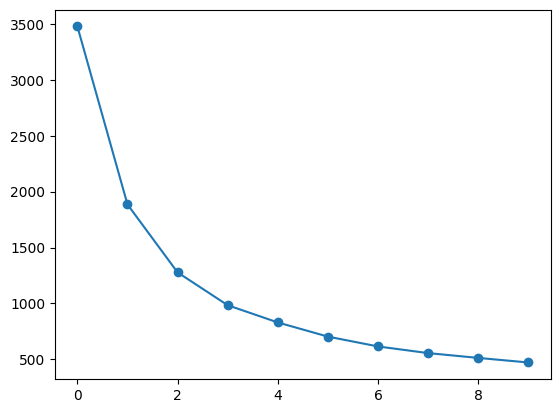

In [51]:
inertia = []
for i in np.arange(1,11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scaled_RFM)
    inertia.append(kmeans.inertia_)

plt.plot(inertia, marker="o");

In [52]:
#Label the data points
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_RFM)
RFM["Clusters"] = (kmeans.labels_+1)
RFM

,Recency,Frequency,Monetory,Clusters
Cust_id,,,,
cc-blkb-100,68,6,81361.33,1
cc-blkb-1000,165,5,129317.13,1
cc-blkb-1001,12,5,88809.72,1
cc-blkb-1002,384,1,24092.04,2
cc-blkb-1003,171,5,98625.66,1
...,...,...,...,...
cc-blkb-995,6,6,165824.43,1
cc-blkb-996,148,2,51582.74,3
cc-blkb-997,30,5,107863.93,1


In [53]:
#Analyze the clusters
group= RFM.groupby(["Clusters"])[['Recency', 'Frequency', 'Monetory']].mean()
group

,Recency,Frequency,Monetory
Clusters,,,
1,78.049563,5.845481,126468.099125
2,301.420664,2.025830,40781.742952
3,85.693578,3.227523,60834.913046


In [54]:
def func(row):
    if row["Clusters"] ==3:
        return 'Average Customers'
    elif row["Clusters"] ==2:
        return 'Top Customers'
    else:
        return 'Lapsed Customers'

In [55]:
RFM['Status'] = RFM.apply(func,axis=1)
RFM

,Recency,Frequency,Monetory,Clusters,Status
Cust_id,,,,,
cc-blkb-100,68,6,81361.33,1,Lapsed Customers
cc-blkb-1000,165,5,129317.13,1,Lapsed Customers
cc-blkb-1001,12,5,88809.72,1,Lapsed Customers
cc-blkb-1002,384,1,24092.04,2,Top Customers
cc-blkb-1003,171,5,98625.66,1,Lapsed Customers
...,...,...,...,...,...
cc-blkb-995,6,6,165824.43,1,Lapsed Customers
cc-blkb-996,148,2,51582.74,3,Average Customers
cc-blkb-997,30,5,107863.93,1,Lapsed Customers


In [56]:
result = RFM["Status"].value_counts()
result

Status
Average Customers    545
Lapsed Customers     343
Top Customers        271
Name: count, dtype: int64

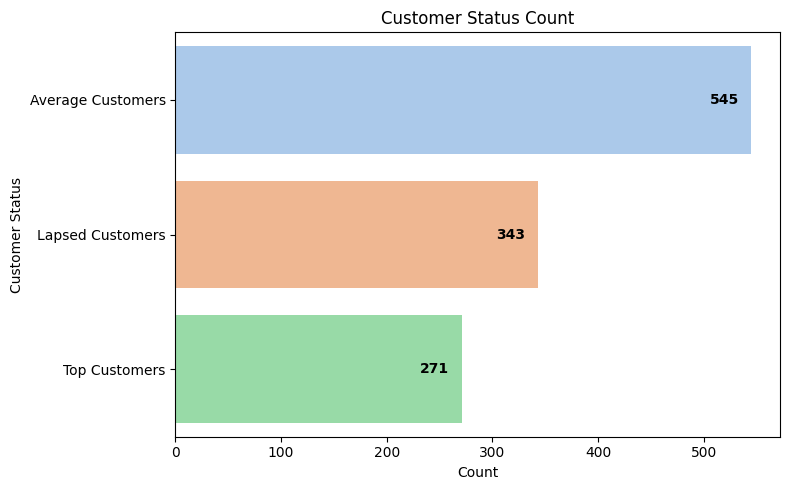

In [60]:
colors = ['#FFB3BA', '#FFDFBA', '#BFD8B8']  

df1 = result.reset_index()
df1.columns = ['Status', 'Count']


plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df1, y='Status', x='Count', palette='pastel')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, fontweight='bold', padding = -30)

plt.title("Customer Status Count")
plt.xlabel("Count")
plt.ylabel("Customer Status")
plt.tight_layout()
plt.show()

In [ ]:
#List of Top Customers
top_customer_ids = RFM.loc[RFM['Status'] == 'Top Customers'].index

top_customers_df = df[df['Cust_id'].isin(top_customer_ids)][['Cust_id']]
print(top_customers_df)


           Cust_id
22     cc-blkb-366
27     cc-blkb-756
30     cc-blkb-563
38     cc-blkb-326
46     cc-blkb-353
...            ...
4307   cc-blkb-671
4313  cc-blkb-1097
4314   cc-blkb-451
4316   cc-blkb-433
4330   cc-blkb-498

[549 rows x 1 columns]


In [59]:
status_list = ['Top Customers', 'Average Customers', 'Lapsed Customers']

filtered_rfm = RFM[RFM['Status'].isin(status_list)]

final_df = filtered_rfm.reset_index()[['Cust_id', 'Status']]

final_df.to_csv('customer_status_list.csv', index=False)
print(final_df)


           Cust_id             Status
0      cc-blkb-100   Lapsed Customers
1     cc-blkb-1000   Lapsed Customers
2     cc-blkb-1001   Lapsed Customers
3     cc-blkb-1002      Top Customers
4     cc-blkb-1003   Lapsed Customers
...            ...                ...
1154   cc-blkb-995   Lapsed Customers
1155   cc-blkb-996  Average Customers
1156   cc-blkb-997   Lapsed Customers
1157   cc-blkb-998  Average Customers
1158   cc-blkb-999  Average Customers

[1159 rows x 2 columns]
